In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
from sklearn.metrics import r2_score
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

import renom as rm
from renom.core import get_gpu
from renom.optimizer import Adam
from renom.cuda import set_cuda_active

from renom_rg.api.regression.gcnn import GCNet
from renom_rg.api.utility.feature_graph import get_corr_graph, get_kernel_graph, get_dbscan_graph

set_cuda_active(False)
np.random.seed(1984)

In [2]:
batch_size = 15
epochs = 40
fc_unit = 100
channels = (5, 10)
num_neighbors = 3
gamma = 0.1

In [3]:
boston_data = load_boston()

scaler = StandardScaler()
boston_data_x = boston_data.data
# boston_data_x = scaler.fit_transform(boston_data.data)

scaler = StandardScaler()
boston_data_y = boston_data.target.reshape(-1, 1)
# boston_data_y = scaler.fit_transform(boston_data.target.reshape(-1, 1))

X_train, X_test = np.array(train_test_split(boston_data_x, test_size = 0.3))
y_train, y_test = np.array(train_test_split(boston_data_y, test_size = 0.3))
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

X_train = (X_train / X_train.max(0))
X_test = (X_test / X_test.max(0))

In [4]:
feature_graph = get_corr_graph(X_train, num_neighbors)
# feature_graph = get_kernel_graph(X_train, num_neighbors, gamma)
# feature_graph = get_dbscan_graph(X_train, num_neighbors)

In [5]:
network = GCNet(neighbors=num_neighbors, feature_graph=feature_graph, fc_unit=fc_unit, channels=channels)
optimizer = Adam()

learning_curve = []
test_curve = []

for i in range(epochs):
    N = X_train.shape[0]
    perm = np.random.permutation(N)
    loss = 0
    bar = tqdm(range(N//batch_size))
    for j in bar:
        index = perm[j*batch_size:(j+1)*batch_size]
        train_batch_x = X_train[index].reshape(-1, 1, X_train.shape[1], 1)
        train_batch_y = y_train[index]

        # Loss function
        network.set_models(inference=False)
        with network.train():
            l = rm.mse(network(train_batch_x), train_batch_y)

        # Back propagation
        grad = l.grad()

        # Update
        grad.update(optimizer)
        loss += l.as_ndarray()
        bar.set_description("epoch: {} loss: {}".format(i, l.as_ndarray()))
        bar.update(1)
        
    train_loss = loss / (N//batch_size)
    learning_curve.append(train_loss)

    # Validation
    network.set_models(inference=True)
    N = X_test.shape[0]
    
    pred = network(X_test.reshape(-1, 1, X_test.shape[1], 1))
    test_loss = rm.mse(pred, y_test)
    test_curve.append(test_loss)
    print("epoch:{} train_loss: {} test_loss: {}".format(i, train_loss, test_loss))

    print("epoch {} R2:{}".format(i, r2_score(y_test.reshape(-1,), pred.reshape(-1,))))

epoch: 2 loss: 186.82748413085938:   0%|          | 0/23 [00:00<?, ?it/s]

epoch:0 train_loss: 280.64160288935125 test_loss: 286.0478515625
epoch 0 R2:-5.000671571864656
epoch:1 train_loss: 228.68256875743037 test_loss: 191.1299591064453
epoch 1 R2:-3.0094977124258726


epoch: 3 loss: 39.52004623413086:  91%|█████████▏| 21/23 [00:00<00:00, 104.41it/s] 

epoch:2 train_loss: 106.49937140423319 test_loss: 53.18112564086914
epoch 2 R2:-0.11562630531208784


epoch: 4 loss: 32.855201721191406:  83%|████████▎ | 19/23 [00:00<00:00, 105.41it/s]

epoch:3 train_loss: 48.6308128108149 test_loss: 48.52216720581055
epoch 3 R2:-0.01789122043871605


epoch: 5 loss: 16.278783798217773: 100%|██████████| 23/23 [00:00<00:00, 118.06it/s]

epoch:4 train_loss: 44.84051633917767 test_loss: 48.707218170166016
epoch 4 R2:-0.021773309023451093



epoch: 7 loss: 62.08918762207031:   9%|▊         | 2/23 [00:00<00:00, 94.95it/s] 

epoch:5 train_loss: 45.152597012727156 test_loss: 48.18781661987305
epoch 5 R2:-0.010877310389996175
epoch:6 train_loss: 41.76972638005795 test_loss: 47.949825286865234
epoch 6 R2:-0.005884747206994945


  0%|          | 0/23 [00:00<?, ?it/s]

epoch:7 train_loss: 42.65979675624681 test_loss: 48.25782012939453
epoch 7 R2:-0.012345822050501054
epoch:8 train_loss: 41.5605121695477 test_loss: 48.12685775756836
epoch 8 R2:-0.0095984567729952


  0%|          | 0/23 [00:00<?, ?it/s]

epoch:9 train_loss: 40.60788527778957 test_loss: 48.49269485473633
epoch 9 R2:-0.01727293790670026
epoch:10 train_loss: 41.841080582660176 test_loss: 48.462093353271484
epoch 10 R2:-0.01663109217910863


epoch: 12 loss: 49.204593658447266:  91%|█████████▏| 21/23 [00:00<00:00, 128.36it/s]

epoch:11 train_loss: 41.20812764375106 test_loss: 49.31869888305664
epoch 11 R2:-0.034600720015668385


epoch: 13 loss: 8.857555389404297:  70%|██████▉   | 16/23 [00:00<00:00, 96.31it/s] 

epoch:12 train_loss: 41.272099038828976 test_loss: 49.19621276855469
epoch 12 R2:-0.032031293795363514


epoch: 14 loss: 79.2044448852539:  70%|██████▉   | 16/23 [00:00<00:00, 86.31it/s]  

epoch:13 train_loss: 41.45919484677522 test_loss: 50.49050521850586
epoch 13 R2:-0.059182711252970144


epoch: 15 loss: 27.66481590270996:  83%|████████▎ | 19/23 [00:00<00:00, 106.06it/s] 

epoch:14 train_loss: 41.42561108133067 test_loss: 48.952239990234375
epoch 14 R2:-0.02691320819997922


epoch: 16 loss: 26.130735397338867:  78%|███████▊  | 18/23 [00:00<00:00, 98.46it/s]

epoch:15 train_loss: 40.610383241072945 test_loss: 49.74162292480469
epoch 15 R2:-0.04347282321292245


epoch: 17 loss: 63.82301712036133: 100%|██████████| 23/23 [00:00<00:00, 118.68it/s] 


epoch:16 train_loss: 41.69004871534265 test_loss: 50.5510139465332
epoch 16 R2:-0.06045215505239199


epoch: 18 loss: 40.085548400878906:  87%|████████▋ | 20/23 [00:00<00:00, 106.99it/s]

epoch:17 train_loss: 40.30181395489237 test_loss: 49.040279388427734
epoch 17 R2:-0.028760183871612277


epoch: 19 loss: 10.387763023376465:  87%|████████▋ | 20/23 [00:00<00:00, 109.90it/s]

epoch:18 train_loss: 40.65287905154021 test_loss: 50.696495056152344
epoch 18 R2:-0.06350399737219714


epoch: 20 loss: 54.53190231323242:  78%|███████▊  | 18/23 [00:00<00:00, 89.33it/s] 

epoch:19 train_loss: 39.61640366264012 test_loss: 49.59153366088867
epoch 19 R2:-0.04032430594966541


epoch: 21 loss: 19.70414924621582: 100%|██████████| 23/23 [00:00<00:00, 116.35it/s] 

epoch:20 train_loss: 40.42038826320482 test_loss: 49.557716369628906
epoch 20 R2:-0.0396148185294567



epoch: 22 loss: 28.428987503051758:  91%|█████████▏| 21/23 [00:00<00:00, 113.50it/s]

epoch:21 train_loss: 38.33108437579611 test_loss: 51.181976318359375
epoch 21 R2:-0.07368832431713357


epoch: 23 loss: 48.323848724365234: 100%|██████████| 23/23 [00:00<00:00, 118.14it/s]

epoch:22 train_loss: 39.619425649228305 test_loss: 49.345375061035156
epoch 22 R2:-0.03516037472945088



epoch: 25 loss: 23.066160202026367:   0%|          | 0/23 [00:00<?, ?it/s]

epoch:23 train_loss: 41.75997360892918 test_loss: 49.2335090637207
epoch 23 R2:-0.03281362448402447
epoch:24 train_loss: 40.21381369881008 test_loss: 49.971282958984375
epoch 24 R2:-0.04829055313409292


epoch: 27 loss: 51.77092361450195:   0%|          | 0/23 [00:00<?, ?it/s]

epoch:25 train_loss: 40.41107969698699 test_loss: 49.39331817626953
epoch 25 R2:-0.03616611690422378
epoch:26 train_loss: 40.28149372598399 test_loss: 50.008758544921875
epoch 26 R2:-0.049076763532047485


epoch: 29 loss: 30.069963455200195:   0%|          | 0/23 [00:00<?, ?it/s]

epoch:27 train_loss: 39.11371092174364 test_loss: 49.57713317871094
epoch 27 R2:-0.04002211476468576
epoch:28 train_loss: 40.102998526200004 test_loss: 50.48429489135742
epoch 28 R2:-0.059052521811026715


epoch: 31 loss: 58.60007095336914:   4%|▍         | 1/23 [00:00<00:00, 68.27it/s]

epoch:29 train_loss: 41.19264664857284 test_loss: 49.96098709106445
epoch 29 R2:-0.048074696685912466
epoch:30 train_loss: 41.01120368294094 test_loss: 50.231903076171875
epoch 30 R2:-0.05375786119290016


  0%|          | 0/23 [00:00<?, ?it/s]

epoch:31 train_loss: 40.56193318574325 test_loss: 51.220741271972656
epoch 31 R2:-0.07450156673001751
epoch:32 train_loss: 41.323359655297324 test_loss: 49.412437438964844
epoch 32 R2:-0.03656720079174014


  0%|          | 0/23 [00:00<?, ?it/s]

epoch:33 train_loss: 40.911223639612615 test_loss: 49.47282028198242
epoch 33 R2:-0.03783391093983535
epoch:34 train_loss: 41.11044651529063 test_loss: 51.817359924316406
epoch 34 R2:-0.08701742074062002


epoch: 37 loss: 53.67467498779297:   0%|          | 0/23 [00:00<?, ?it/s]

epoch:35 train_loss: 38.99479708464249 test_loss: 49.422298431396484
epoch 35 R2:-0.03677406302726505
epoch:36 train_loss: 40.7182095154472 test_loss: 49.823158264160156
epoch 36 R2:-0.04518329352873596


epoch: 38 loss: 41.01039123535156:  87%|████████▋ | 20/23 [00:00<00:00, 121.01it/s] 

epoch:37 train_loss: 40.42260916336723 test_loss: 50.458778381347656
epoch 37 R2:-0.05851719784603282


epoch: 39 loss: 62.064517974853516:  87%|████████▋ | 20/23 [00:00<00:00, 89.54it/s]

epoch:38 train_loss: 39.48991211600926 test_loss: 49.939483642578125
epoch 38 R2:-0.047623609811557444


epoch: 39 loss: 73.0392074584961: 100%|██████████| 23/23 [00:00<00:00, 106.22it/s] 

epoch:39 train_loss: 39.08320524381555 test_loss: 49.54296875
epoch 39 R2:-0.039305486596370454


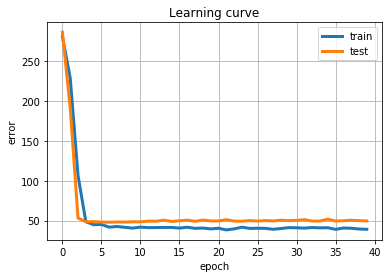

In [6]:
# Learning curve.
plt.plot(learning_curve, linewidth=3, label="train")
plt.plot(test_curve, linewidth=3, label="test")
plt.title("Learning curve")
plt.ylabel("error")
plt.xlabel("epoch")
plt.legend()
plt.grid()
plt.show()